# Exploring related phrases to Memory Issues

In [1]:
SEED = 123581119
import os
import random as rn
import numpy as np
from numpy import dot
from numpy.linalg import norm

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

import pandas as pd
import ast
from gensim.models import Word2Vec, FastText, KeyedVectors
import util
from umap import UMAP
import csv

## Load Tensorflow issues

In [2]:
tf_open = pd.read_csv("tf_tokenized.csv")
util.convert_tolist(tf_open, ['lemmas', 'bigrams','noun_noun', 'adj_noun', 'verb_noun'])
tf_open["preprocessed"] = tf_open["preprocessed"].map(lambda x: x.split())
tf_open["bigrams"] = tf_open["bigrams"].map(lambda x: ["__".join(k.split()) for k in x])
tf_open["noun_noun"] = tf_open["noun_noun"].map(lambda x: ["__".join(k.split()) for k in x])
tf_open.head()

issue_id                 created_at  \
0     54551  2022-02-24 23:37:16+00:00   
1     54550  2022-02-24 23:29:48+00:00   
2     54549  2022-02-24 23:27:45+00:00   
3     54548  2022-02-24 23:04:04+00:00   
4     54547  2022-02-24 22:51:09+00:00   

                                               title  \
0   Add spmd_parameters_shardings to HloModuleProto.   
1  Fixes : https://github.com/tensorflow/tensorfl...   
2  Append the path when the metadata was not foun...   
3                  Delete another ancient Dockerfile   
4  Remove java-related flags from .bazelrc that a...   

                                        preprocessed  \
0  [add, spmd_parameters_shardings, to, hlomodule...   
1                                    [fixes, :, url]   
2  [append, the, path, when, the, metadata, was, ...   
3             [delete, another, ancient, dockerfile]   
4  [remove, java-related, flags, from, .bazelrc, ...   

                                              lemmas  \
0    [add, spmd_parameters_sharding, hlomoduleproto]   
1                                         [fix, url]   
2  [append, path, metadata, find, error, message,...   
3                      [delete, ancient, dockerfile]   
4  [remove, java, relate, flag, .bazelrc, ignore,...   

                                    bigrams         noun_noun  \
0          [add__spmd_parameters_shardings]                []   
1                                        []                []   
2       [error__message, easier__debugging]  [error__message]   
3                     [ancient__dockerfile]                []   
4  [remove__java, related__flags, bazel__5]                []   

               adj_noun                        verb_noun  
0                    []  [add spmd_parameters_shardings]  
1                    []                               []  
2    [easier debugging]                               []  
3  [ancient dockerfile]                               []  
4                    []     [remove java, related flags]

## Load Pytorch Issues

In [3]:
pt_open = pd.read_csv("pt_tokenized.csv")
util.convert_tolist(pt_open, ['lemmas', 'bigrams','noun_noun', 'adj_noun', 'verb_noun'])
pt_open["preprocessed"] = pt_open["preprocessed"].map(lambda x: x.split())
pt_open["bigrams"] = pt_open["bigrams"].map(lambda x: ["__".join(k.split()) for k in x])
pt_open["noun_noun"] = pt_open["noun_noun"].map(lambda x: ["__".join(k.split()) for k in x])
pt_open.head()

issue_id                 created_at  \
0     73408  2022-02-25 00:18:58+00:00   
1     73407  2022-02-25 00:18:53+00:00   
2     73406  2022-02-25 00:13:41+00:00   
3     73405  2022-02-25 00:10:16+00:00   
4     73404  2022-02-24 23:57:56+00:00   

                                               title  \
0  [PyTorch] [Model Tracer] Use c10::Synchronized...   
1  [RFC] Implement c10::Synchronized<T>, a basic ...   
2  [fx][acc_tracer] fix defaulted placeholder nor...   
3   [PT-D][FSDP] Implement _clip_grad_norm_ for FSDP   
4                  Pull request to run CI for #72556   

                                        preprocessed  \
0  [pytorch, model, tracer, use, c10::synchronize...   
1  [rfc, implement, c10::synchronized<t>,, a, bas...   
2  [fxacc_tracer, fix, defaulted, placeholder, no...   
3  [pt-dfsdp, implement, _clip_grad_norm_, for, f...   
4          [pull, request, to, run, ci, for, #72556]   

                                              lemmas  \
0  [pytorch, model, tracer, use, c10::synchronize...   
1  [rfc, implement, c10::synchronize, basic, erro...   
2  [fxacc_tracer, fix, default, placeholder, norm...   
3  [pt, -, dfsdp, implement, _, clip_grad_norm, _...   
4                           [pull, request, run, ci]   

                                             bigrams  \
0  [pytorch__model, model__tracer, tracer__use, u...   
1  [rfc__implement, implement__c10::synchronized,...   
2  [fxacc_tracer__fix, fix__defaulted, defaulted_...   
3                                 [dfsdp__implement]   
4                           [pull__request, run__ci]   

                                           noun_noun  \
0  [pytorch__model, pytorch__model__tracer, model...   
1                         [synchronization__wrapper]   
2    [fxacc_tracer__fix, placeholder__normalization]   
3  [implement___, implement___clip_grad_norm, _cl...   
4                                                 []   

                                            adj_noun  \
0                                                 []   
1                                      [basic error]   
2                                                 []   
3  [dfsdp implement, dfsdp implement _, dfsdp imp...   
4                                                 []   

                                           verb_noun  
0                                   [protected data]  
1  [avoiding synchronization, avoiding synchroniz...  
2  [defaulted placeholder, defaulted placeholder ...  
3                                                 []  
4                             [pull request, run ci]

## Create word embeddings from noun phrases

In [4]:
param_grid = {'w2v': {'variant': ['cbow'], 'window': [1], 'min_count': [2]}}
phrase = "memory__leak"

def top_similar(model, phrase, topn=10):
    """Get top n tokens based on cosine similarity"""
    result = []
    
    idx = model.key_to_index[phrase]    
    words = list(model.key_to_index.keys())
    wv = [model[word] for word in words]

    reducer = UMAP(n_components=50, metric='cosine', n_neighbors = 15, min_dist=0.1, random_state=SEED)
    reduced_wv = reducer.fit_transform(wv)

    cos_sim = []
    for i, word in enumerate(words):    
        cos_s = dot(reduced_wv[idx], reduced_wv[i]) / (norm(reduced_wv[idx])*norm(reduced_wv[i]))
        cos_sim.append(cos_s)

    max_idx = np.argpartition(cos_sim, -(topn+1))[-(topn+1):]

    for i in max_idx:
        if words[i] == phrase:
            continue
        else:
            print(f"Word = {words[i]}, Cos = {cos_sim[i]}, 2d = {reduced_wv[i,:2]}")
            result.append((words[i], reduced_wv[i,:2]))
    return result

### Tensorflow

In [5]:
files = util.save_models(tf_open, "noun_noun", param_grid)
tf_models = {}
for name in files:    
    tf_models[name] = KeyedVectors.load_word2vec_format(name, binary=True) 
vcb, df = util.compare_models([(file, tf_models[file]) for file in files], positive='memory__leak', topn=10)
df

tf_noun_noun_w2v_cbow_1_2.bin
0            sum__version 0.215
1          detection__api 0.189
2          tflite__models 0.189
3         tensorrt__model 0.184
4          spark__dataset 0.183
5      flops__calculation 0.181
6            tensor__size 0.178
7          error__message 0.161
8            input__check 0.160
9       type__annotations 0.159

In [6]:
tf_model = tf_models["tf_noun_noun_w2v_cbow_1_2.bin"]
tf_result = top_similar(tf_model, phrase)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Word = detection__api, Cos = 0.9996058940887451, 2d = [4.4813075 5.6130233]
Word = test__failures, Cos = 0.9996151328086853, 2d = [4.5318165 5.7051873]
Word = model__conversion, Cos = 0.999634325504303, 2d = [4.574291  5.8588696]
Word = semantics__documentation, Cos = 0.9996699094772339, 2d = [4.625629  5.7343464]
Word = performance__issue, Cos = 0.9997377395629883, 2d = [4.4784737 5.6825895]
Word = flops__calculation, Cos = 0.9997754096984863, 2d = [4.5859275 5.6497316]
Word = input__check, Cos = 0.9998419284820557, 2d = [4.4298086 5.802768 ]
Word = tflite__models, Cos = 0.9997787475585938, 2d = [4.605886 5.443246]
Word = sum__version, Cos = 0.9999278783798218, 2d = [4.426961 5.682889]
Word = docker__container, Cos = 0.999897837638855, 2d = [4.4541173 5.66988  ]


### Pytorch

In [7]:
files = util.save_models(pt_open, "noun_noun", param_grid, "pt")
pt_models = {}
for name in files:    
    pt_models[name] = KeyedVectors.load_word2vec_format(name, binary=True) 
vcb, df = util.compare_models([(file, pt_models[file]) for file in files], positive='memory__leak', topn=10)
df

pt_noun_noun_w2v_cbow_1_2.bin
0         dispatch__table 0.328
1       _torch_function__ 0.268
2     cudnn__convolutions 0.266
3         pytorch__mobile 0.253
4          function__name 0.241
5            async__error 0.224
6        member__function 0.217
7      _main__.testjitcpu 0.217
8         torch__function 0.216
9         rate__scheduler 0.214

In [8]:
pt_model = pt_models["pt_noun_noun_w2v_cbow_1_2.bin"]
pt_result = top_similar(pt_model, phrase)

Word = _torch_function, Cos = 0.999715268611908, 2d = [6.5330954 5.44529  ]
Word = layer__normalization, Cos = 0.9997236728668213, 2d = [6.3093753 5.3016357]
Word = _torch_function__, Cos = 0.9998619556427002, 2d = [6.461629  5.5160117]
Word = cudnn__error, Cos = 0.9998939633369446, 2d = [6.392704  5.3620925]
Word = cudnn__convolutions, Cos = 0.999915599822998, 2d = [6.3849897 5.342786 ]
Word = planning__strategy, Cos = 0.9997354745864868, 2d = [6.384632  5.2915354]
Word = reduction__ops, Cos = 0.9998043179512024, 2d = [6.487767 5.562625]
Word = pytorch__mobile, Cos = 0.9998828172683716, 2d = [6.32681  5.429134]
Word = source__location, Cos = 0.9997460246086121, 2d = [6.5178223 5.561855 ]
Word = profiling__executor, Cos = 0.9998455047607422, 2d = [6.360934  5.3665586]


In [9]:
pt_result

[('_torch_function', array([6.5330954, 5.44529  ], dtype=float32)),
 ('layer__normalization', array([6.3093753, 5.3016357], dtype=float32)),
 ('_torch_function__', array([6.461629 , 5.5160117], dtype=float32)),
 ('cudnn__error', array([6.392704 , 5.3620925], dtype=float32)),
 ('cudnn__convolutions', array([6.3849897, 5.342786 ], dtype=float32)),
 ('planning__strategy', array([6.384632 , 5.2915354], dtype=float32)),
 ('reduction__ops', array([6.487767, 5.562625], dtype=float32)),
 ('pytorch__mobile', array([6.32681 , 5.429134], dtype=float32)),
 ('source__location', array([6.5178223, 5.561855 ], dtype=float32)),
 ('profiling__executor', array([6.360934 , 5.3665586], dtype=float32))]

In [10]:
def get_range(result):
    """Returns x1, x2, x1 min max and x2 min max"""
    x1 = np.zeros(shape=(len(result),))
    x2 = np.zeros(shape=(len(result),))
    for i, t in enumerate(result):
        x1[i] = t[1][0]
        x2[i] = t[1][1]
    
    return x1, x2, np.min(x1),np.max(x1), np.min(x2), np.max(x2)
   

## Plot similar phrases to Memory Leak

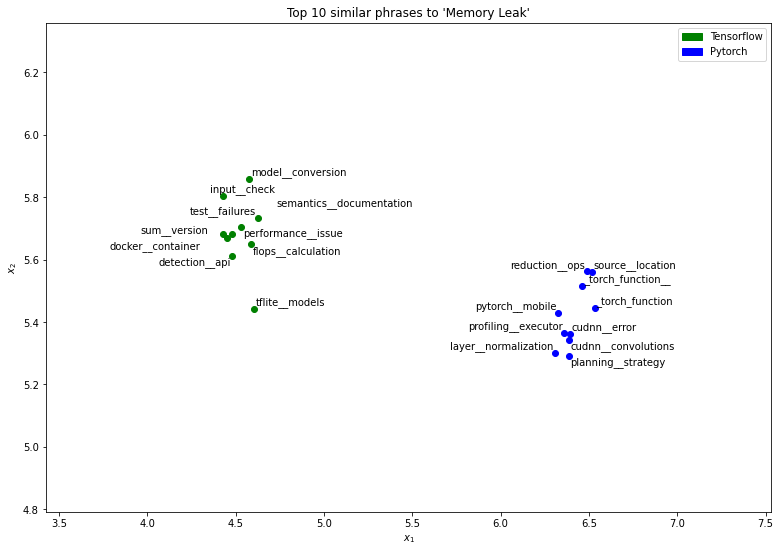

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text

fig, ax = plt.subplots(1,1, figsize=(13,9))

ax.set_title("Top 10 similar phrases to 'Memory Leak'")
ax.set_xlabel("$ x_1 $")
ax.set_ylabel("$ x_2 $")

tf_x1, tf_x2, tf_x1_min, tf_x1_max, tf_x2_min, tf_x2_max = get_range(tf_result)

ax.plot(tf_x1, tf_x2, 'go')
pt_x1, pt_x2, pt_x1_min, pt_x1_max, pt_x2_min, pt_x2_max = get_range(pt_result)
ax.plot(pt_x1, pt_x2, 'bo')

x1_min = np.min([tf_x1_min, pt_x1_min]) - 1.0
x2_min = np.min([tf_x2_min, pt_x2_min]) - 0.5
x1_max = np.max([tf_x1_max, pt_x1_max]) + 1.0
x2_max = np.max([tf_x2_max, pt_x2_max]) + 0.5

ax.set_xlim([x1_min, x1_max])
ax.set_ylim([x2_min, x2_max])

legend_elements = [Patch(facecolor='green', edgecolor='g',label='Tensorflow'),
                   Patch(facecolor='blue', edgecolor='b',label='Pytorch')]
ax.legend(handles=legend_elements, loc='upper right')

    
tf_txt = [plt.text(r[1][0], r[1][1], r[0], ha='center', va='center') for r in tf_result]
pt_txt = [plt.text(r[1][0], r[1][1], r[0], ha='center', va='center') for r in pt_result]
adjust_text(tf_txt)
adjust_text(pt_txt)
plt.savefig('memory_issues.jpg',bbox_inches='tight', dpi=150)

We see different type of problems related to memory issues for each project. Both projects report memory issues related to mobile versions, as mobile devices are more sensitive to memory load. we also see gpu and cuda related problems in pytorch project issues. 

## Save models compatible with tensorflow embedding projection
This will enable us to further explore these embeddings.

In [12]:
util.write_model(tf_models, "tf_noun_noun_w2v_cbow_1_2.bin")
util.write_model(pt_models, "pt_noun_noun_w2v_cbow_1_2.bin")